In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [76]:
x = torch.tensor([i for i in range(-50, 50)])

In [77]:
def randvec(r1, r2, shape):
    return (r1 - r2) * torch.rand(X.shape) + r2

In [78]:
y = randvec(-500, 500, X.shape) + x + x.pow(2)

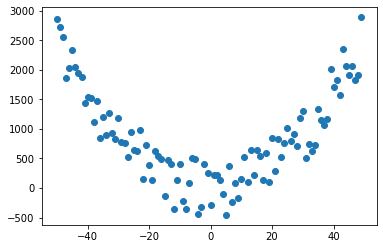

In [74]:
plt.scatter(x, y)